In [6]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import random
from collections import deque

class RoutingEnv(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 4}

    def __init__(self, num_machines=3, max_steps=1000):
        super(RoutingEnv, self).__init__()

        self.max_steps = max_steps

        self.num_machines = num_machines
        self.query_types = ["SELECT", "JOIN"]
        self.query_cost = {"SELECT": 3, "JOIN": 10}  # processing time in steps

        self.query_type_map = {name: i for i, name in enumerate(self.query_types)}
        self.num_query_types = len(self.query_types)

        # Observation: CPU util + pending queries per type for each machine
        self.observation_space = spaces.Box(
            low=0,
            high=1,
            shape=(self.num_machines * (1 + self.num_query_types),),
            dtype=np.float32,
        )
        self.action_space = spaces.Discrete(self.num_machines)

        self.cpu_util = np.zeros(self.num_machines)
        self.cpu_recovery_rates = np.random.uniform(0.01, 0.05, size=self.num_machines)
        self.query_queues = [[] for _ in range(self.num_machines)]  # Each machine has a list of (qtype, remaining_time, arrival_time)

        self.time_step = 0
        self.current_query = None

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.cpu_util = np.random.uniform(0.1, 0.3, size=self.num_machines)
        self.cpu_recovery_rates = np.random.uniform(0.01, 0.05, size=self.num_machines)
        self.query_queues = [[] for _ in range(self.num_machines)]
        self.time_step = 0
        self.current_query = self._generate_query()
        return self._get_obs(), {}

    def _generate_query(self):
        return random.choice(self.query_types)

    def _get_obs(self):
        obs = []
        for i in range(self.num_machines):
            obs.append(self.cpu_util[i])
            type_counts = [0] * self.num_query_types
            for q in self.query_queues[i]:
                qtype_idx = self.query_type_map[q[0]]
                type_counts[qtype_idx] += 1
            obs.extend(type_counts)
        return np.array(obs, dtype=np.float32)

    def step(self, action):
        reward = 0.0
        self.time_step += 1

        # Assign current query to chosen machine
        query_type = self.current_query
        qtype_idx = self.query_type_map[query_type]
        processing_time = self.query_cost[query_type]
        self.query_queues[action].append([query_type, processing_time, self.time_step])
        self.cpu_util[action] += 0.01 * processing_time

        # Process one step of queries and check for completions
        for i in range(self.num_machines):
            updated_queue = []
            for query in self.query_queues[i]:
                query[1] -= 1  # decrease remaining_time
                if query[1] <= 0:
                    # Query finished, reward is negative latency
                    latency = self.time_step - query[2]
                    reward += -latency
                else:
                    updated_queue.append(query)
            self.query_queues[i] = updated_queue
            self.cpu_util[i] = max(self.cpu_util[i] - self.cpu_recovery_rates[i], 0)

        if reward == 0:
            reward = -0.1  # small penalty for idle step

        self.current_query = self._generate_query()
        obs = self._get_obs()
        terminated = False
        truncated = self.time_step >= self.max_steps
        info = {}

        return obs, reward, terminated, truncated, info

    def render(self):
        print(f"\n--- TIME STEP {self.time_step} ---")
        for i in range(self.num_machines):
            load_summary = ", ".join(
                f"{self.query_type_map[q[0]]}:{q[1]}" for q in self.query_queues[i]
            )
            print(
                f"Machine {i}: CPU={self.cpu_util[i]:.2f}, "
                f"Queue=[{load_summary}], Recovery Rate={self.cpu_recovery_rates[i]:.3f}"
            )

    def close(self):
        pass

import done
PPO model creation done
PPO model training done


100%|██████████| 100/100 [00:07<00:00, 13.87it/s]


RL agent eval done


100%|██████████| 100/100 [00:00<00:00, 222.31it/s]

Random agent eval done


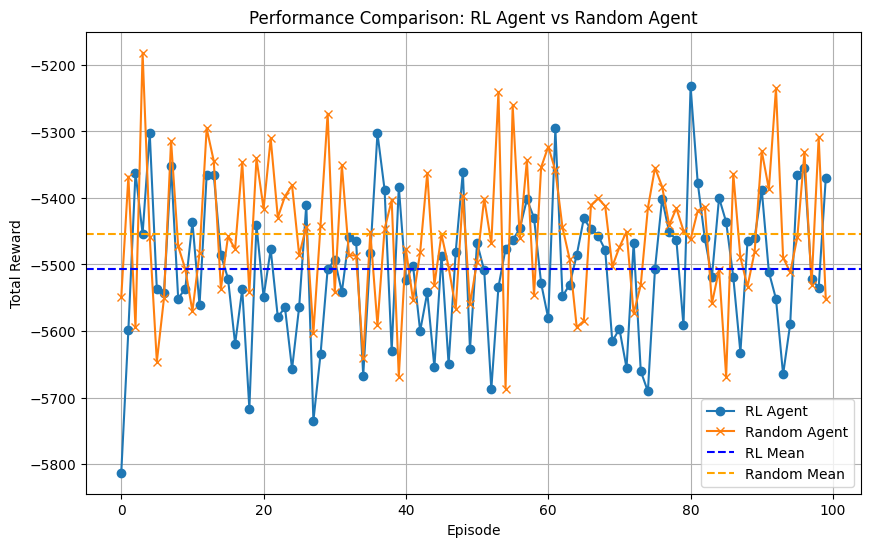

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy
from tqdm import tqdm

num_machines= 6
# Assume RoutingEnv is already defined
env = RoutingEnv(num_machines=num_machines)
check_env(env, warn=True)

print("import done")
# Train PPO Agent
rl_env = RoutingEnv(num_machines=num_machines, max_steps=100)
model = PPO("MlpPolicy", rl_env, verbose=0)
print("PPO model creation done")

model.learn(total_timesteps=1000_00)
print("PPO model training done")

# Evaluation function for both agents
def evaluate_agent(agent, env, n_episodes=100, is_random=False):
    rewards = []
    for _ in tqdm(range(n_episodes)):
        obs, _ = env.reset()
        done = False
        total_reward = 0
        while not done:
            if is_random:
                action = env.action_space.sample()
            else:
                action, _ = agent.predict(obs)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
        rewards.append(total_reward)
    return rewards

# Evaluate both agents
rl_rewards = evaluate_agent(model, RoutingEnv(num_machines=num_machines))
print("RL agent eval done")

random_rewards = evaluate_agent(None, RoutingEnv(num_machines=num_machines), is_random=True)
print("Random agent eval done")


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(rl_rewards, label="RL Agent", marker="o")
plt.plot(random_rewards, label="Random Agent", marker="x")
plt.axhline(np.mean(rl_rewards), color='blue', linestyle='--', label="RL Mean")
plt.axhline(np.mean(random_rewards), color='orange', linestyle='--', label="Random Mean")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Performance Comparison: RL Agent vs Random Agent")
plt.legend()
plt.grid(True)
plt.show()